# Compare the surface speed and KE simulated by the tide-only 1-layer global MOM6 with JSL and SAH drag with the original version

JSL drag: /g/data/nm03/lxy581/archive/tides_025_JSL/

SAH drag: /g/data/nm03/lxy581/archive/tides_025_SAH_mag/

1st year (M2 only): output000 - output011/ocean_interior.nc

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

### MOM6: Load the global speed

In [3]:
def load_speed(dir,itime):
    data = xr.open_dataset(dir)
    lon = np.array(data.xh)
    lat = np.array(data.yh)
    spd = np.array(data['speed'].isel({'time':itime}))
    ds  = xr.Dataset(data_vars={"spd": (["ny","nx"], spd)},
                    coords={"lat": (["ny"], lat), 
                            "lon": (["nx"], lon)})
    return ds

In [4]:
def global_monthly_mean_KE(dir):
    data = xr.open_dataset(dir)
    KE = 0.5*data['speed']**2
    mKE = KE.mean(dim=["time","yh","xh"],skipna=True)
    return mKE

In [5]:
def mean_KE(dir,itime):
    data = xr.open_dataset(dir)
    lon = np.array(data.xh)
    lat = np.array(data.yh)
    spd = np.array(data['speed'].isel({'time':itime}))
    KE = 0.5*spd**2
    ds  = xr.Dataset(data_vars={"KE": (["ny","nx"], KE)},
                    coords={"lat": (["ny"], lat), 
                            "lon": (["nx"], lon)})
    return ds

In [7]:
# dir_SAH = '/g/data/nm03/lxy581/archive/tides_025_SAH_mag/output011/ocean_interior.nc'
dir_SAH = '/scratch/nm03/lxy581/mom6/archive/tides_025_SAH_mag/output011/ocean_interior.nc'
ds_SAH = mean_KE(dir_SAH,-6)

0.3.0


In [8]:
dir_JSL = '/g/data/nm03/lxy581/archive/tides_025_JSL/output011/ocean_interior.nc'
ds_JSL = mean_KE(dir_JSL,-6)

In [9]:
topog = xr.open_dataset('/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025/INPUT/ocean_topog.nc')
depth = topog.depth
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

### Plot the time-mean KE

In [10]:
def plot_speed(ds,vmin,vmax,title):
    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    my_cmap = cm.cm.deep
    #my_cmap.set_bad('gray')
    
    p1 = ax1.pcolormesh(ds["lon"], ds["lat"], ds["KE"], transform=ccrs.PlateCarree(), cmap=my_cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Time-mean KE (m$^{2}$ s$^{-2}$)');

In [11]:
def plot_speed_lin(lon,lat,KE,vmin,vmax,title,tick_locs,tick_labels):
    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    my_cmap = cm.cm.balance
    #my_cmap.set_bad('gray')
    
    p1 = ax1.pcolormesh(lon, lat, KE, transform=ccrs.PlateCarree(), cmap=my_cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('');
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

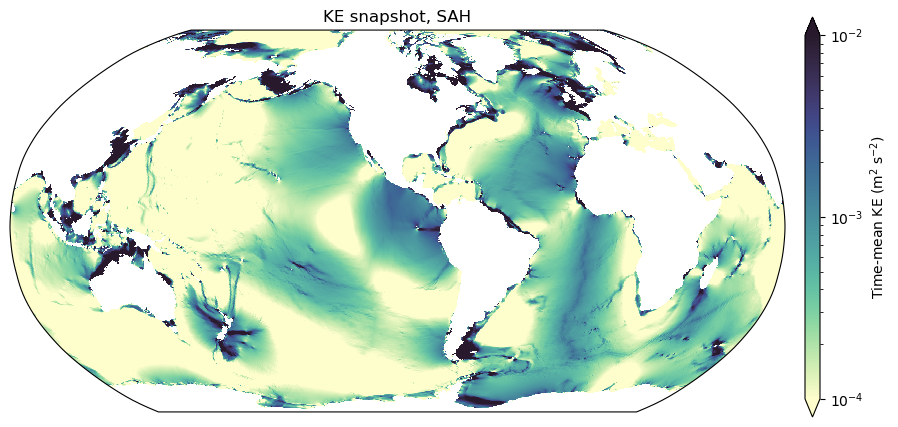

In [12]:
title = 'KE snapshot, SAH'
plot_speed(ds_SAH,1e-4,1e-2,title)
plt.savefig('/g/data/nm03/lxy581/exps_figs/KE_snap_SAH_025.png', dpi=300, bbox_inches='tight')

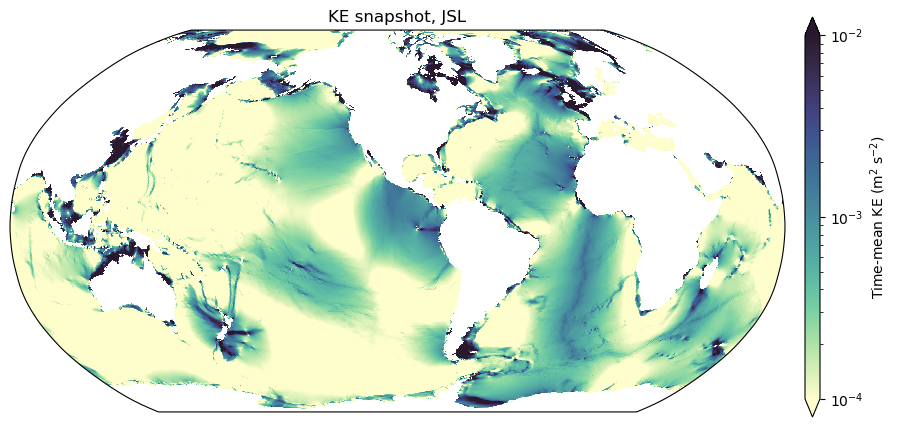

In [13]:
title = 'KE snapshot, JSL'
plot_speed(ds_JSL,1e-4,1e-2,title)
plt.savefig('/g/data/nm03/lxy581/exps_figs/KE_snap_JSL_025.png', dpi=300, bbox_inches='tight')

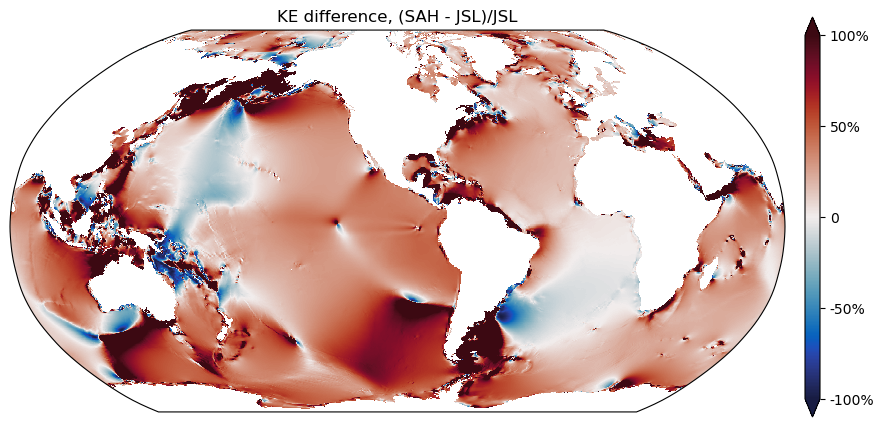

In [14]:
title = 'KE difference, (SAH - JSL)/JSL'
tick_locs = np.array([-1,-0.5,0,0.5,1])
tick_labels = np.array(["-100%","-50%",0,"50%","100%"])
plot_speed_lin(ds_JSL["lon"],ds_JSL["lat"],(ds_SAH["KE"]-ds_JSL["KE"])/ds_JSL["KE"],-1,1,title,tick_locs,tick_labels)
plt.savefig('/g/data/nm03/lxy581/exps_figs/KE_diff_JSL_SAH_025.png', dpi=300, bbox_inches='tight')